In [142]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import csv
from sklearn import cross_validation
%matplotlib inline

In [143]:
def agg_competitor(data, index_start, index_end, skip):
    copy = data.copy()
    copy['Competitor'] = copy.iloc[:,1].map(lambda x: 0)
    i=index_start
    while i < index_end:
        copy.ix[:,i] = ~copy.ix[:,i].isnull()*1
        copy['Competitor'] = copy.iloc[:,i] + copy['Competitor']
        i=i+skip
    return copy['Competitor']

p_mol_mean_price_pre_loe = {}

def max_price_per_presentation():
    data = pd.read_csv('data/data.csv')
    return data['Winning_price_per_standard_unit'].max()   

def days_since_loe(molecule_name, start_date):
    if molecule_name =='Molecule3':
        return float((start_date - datetime(2009,3,1,0,0,0)).days)
    else:
        return float((start_date - datetime(2011,1,1,0,0,0)).days)

def build_presentation_price_dict():
    data = pd.read_csv('data/data.csv')
    p_presentation_dict_train  = {}
    for item in data['Presentation'].unique():
        row = data.ix[data[data['Presentation'] == item]['Winning_price_per_standard_unit'].idxmax()]
        p_presentation_dict_train[row['Presentation']] = row['Winning_price_per_standard_unit']
    return p_presentation_dict_train

def transform_length_of_contract(row):
    value = 0
    if(row['Length_of_contract_in_Months'] < 12):
        value = np.log(row['Length_of_contract_in_Months'])
    return value

def apply_featur_for_no_competition(row):
    value = 0
    if(row['Competitor'] == 0):
        value = p_presentation_dict_train[row['Presentation']]
    return value

def impute_competitor_price(row):
    if pd.isnull(row['Competitor_2nd_Lowest_Price_per_standard_unit']):
        return 0
    return row['Competitor_2nd_Lowest_Price_per_standard_unit']

def process_df(file, cols, is_test):
    copy =pd.read_csv(file)
    copy['Start_date'] = pd.to_datetime(copy['Start_date'])
    copy['End_date_including_extension'] = pd.to_datetime(copy['End_date_including_extension'])
    if is_test == False:
        copy = copy[copy['ID'] != 680]
    copy['Competitor'] = agg_competitor(copy, 16, 34, 2)
    copy = copy[cols]
    copy['Competitor_2nd_Lowest_Price_per_standard_unit'] = copy.apply(lambda row: impute_competitor_price(row), axis=1)
#only drop for train data
    if is_test == False:
        copy = copy.dropna()
    copy.loc[:,'Tenure'] = copy.apply(lambda row: days_since_loe(row['Molecule'], row['Start_date'])/30, axis=1)
    copy['Feature_No_Competition'] = copy.apply(lambda x: apply_featur_for_no_competition(x),axis=1)
    copy.loc[:,'Presentation'] = copy.apply(lambda row: p_presentation_dict_train[row['Presentation']], axis=1)
#    copy['Feature_Small_Contract'] = copy.apply(lambda x: transform_length_of_contract(x),axis=1)
    copy.loc[:,'Contract_Length'] = copy.apply(lambda row: (row['End_date_including_extension'] - row['Start_date']).days/30 , axis=1)
    copy.loc[:,'Length_of_contract_in_Months'] = copy.apply(lambda row: np.log(1./row['Length_of_contract_in_Months']), axis=1)
    copy.loc[:,'Tender_Standard_Unit_per_year'] = copy.apply(lambda row: np.log(row['Tender_Standard_Unit_per_year']), axis=1)
#only drop for train data
    if is_test == False:
        copy=copy[copy['Tenure'] >= 0]
    copy.loc[:,'Tenure'] = copy.apply(lambda row: np.log(row['Tenure']), axis=1)
    copy = copy.drop(['Molecule', 'Start_date', 'End_date_including_extension', 'Account','Province', 'Tender_Type', 'Contract_Length'],1)
    return copy

def generate_feature(is_test):
    col=['Molecule','Account','Winning_price_per_standard_unit','Province','Region','Tender_Type', 'Tender_Standard_Unit_per_year', 'Length_of_contract_in_Months', 'Presentation', 'Start_date', 'End_date_including_extension', 'Competitor', 'Competitor_2nd_Lowest_Price_per_standard_unit']
    file_location = 'data/data.csv'
    if is_test:
        col=['Molecule','Account','Province','Region','Tender_Type', 'Tender_Standard_Unit_per_year', 'Length_of_contract_in_Months', 'Presentation', 'Start_date', 'End_date_including_extension', 'Competitor','Competitor_2nd_Lowest_Price_per_standard_unit']
        file_location = 'data/CAX_Bidding_TEST_Molecule_6_Post_LOE.csv'
    data = process_df(file_location, col, is_test)
    return data.copy()

def prepare_model_X(data):
    data=pd.get_dummies(data)
    y=data.as_matrix()[:,0]
    X=data.as_matrix()[:,1:]
    return X,y

def run_linear_reg(X_train, X_test, y_train, y_test):
    reg=linear_model.LinearRegression()
    reg.fit(X_train,y_train)
    print "Score:" , reg.score(X_test,y_test)
    print "MSE:", mean_squared_error(y_test,reg.predict(X_test))
    plot_scatter(y_test, reg.predict(X_test))
    return reg

def run_gradient_boost(X_train, X_test, y_train, y_test):
    # Fit regression model
    params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls'}
    clf = GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)

    print "mse:", mean_squared_error(y_test, clf.predict(X_test))
    print "score:", clf.score(X_test, y_test)
    plot_scatter(y_test, clf.predict(X_test))
    plot_gb(params, clf)
    return clf

def plot_gb(params, clf):
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_predict(X_test)):
        test_score[i] = clf.loss_(y_test, y_pred)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    
def plot_scatter(y_test, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()

In [144]:
#prepare some globals.
p_presentation_dict_train = build_presentation_price_dict()
max_presentation_train = max_price_per_presentation()

In [145]:
#generate features
features = generate_feature(False)
print features.shape[0], len(features.columns)
feature_test = generate_feature(True)
print feature_test.shape[0], len(features.columns)

639 9
152 9


In [146]:
train_input = prepare_model_X(features)
print "Shape Y:", train_input[1].shape
print "Shape X:", train_input[0].shape
X_train,X_test,y_train,y_test=train_test_split(train_input[0], train_input[1], test_size=0.33, random_state=42)

feature_test=pd.get_dummies(feature_test)
X_test_mtx=feature_test.as_matrix()

Shape Y: (639,)
Shape X: (639, 27)


Score: 0.780837017382
MSE: 1.54125793516


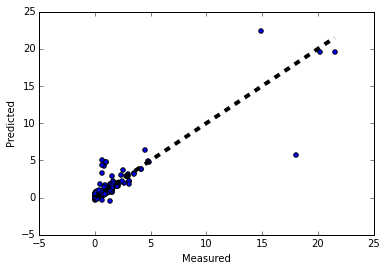

mse: 0.665170480174
score: 0.905414439038


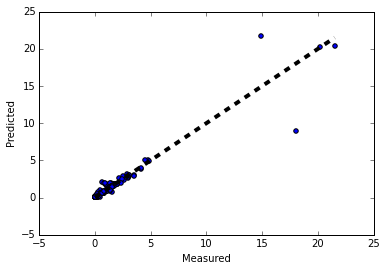

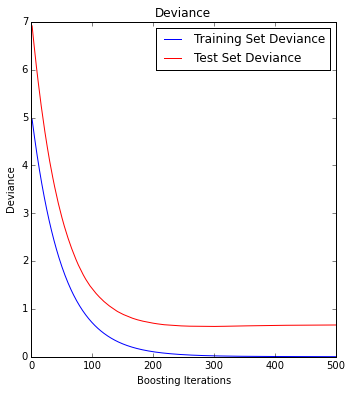

In [147]:
linear_reg = run_linear_reg(X_train, X_test, y_train, y_test)
gradient_boost = run_gradient_boost(X_train, X_test, y_train, y_test)

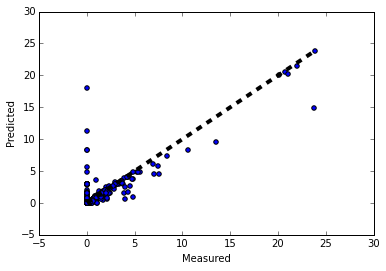

Actual/Competitor


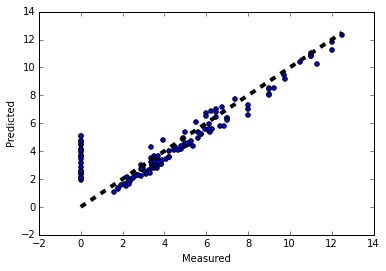

Linear_Predictor/Competitor


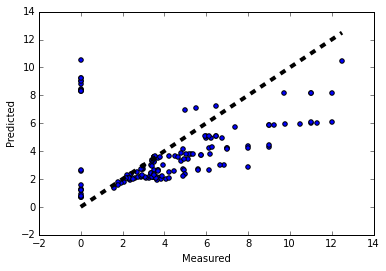

Gradient_Predictor/Competitor


In [157]:
y_test_pred_reg = linear_reg.predict(X_test_mtx)
y_test_pred_gb = gradient_boost.predict(X_test_mtx)
zipped = zip(y_test_pred_reg, y_test_pred_gb)
plot_scatter(features['Competitor_2nd_Lowest_Price_per_standard_unit'], features['Winning_price_per_standard_unit'])
print "Actual/Competitor"
plot_scatter(feature_test['Competitor_2nd_Lowest_Price_per_standard_unit'], y_test_pred_reg)
print "Linear_Predictor/Competitor"
plot_scatter(feature_test['Competitor_2nd_Lowest_Price_per_standard_unit'], y_test_pred_gb)
print "Gradient_Predictor/Competitor"

def merge_gb_linear(row):
    if row['Competitor'] == 0:
        return row['gb']
    return row['linear']

    

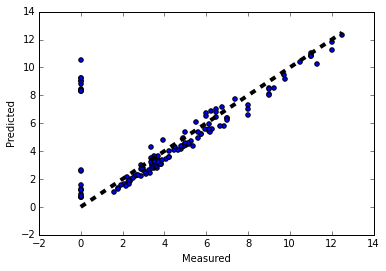

In [158]:
#lr = pd.DataFrame(y_test_pred_reg)
feature_test['linear'] = y_test_pred_reg
feature_test['gb'] = y_test_pred_gb

feature_test['linear'] = feature_test.apply(lambda x: merge_gb_linear(x),axis=1)
y_test_merged = feature_test['linear'].as_matrix()
plot_scatter(feature_test['Competitor_2nd_Lowest_Price_per_standard_unit'], y_test_merged)

In [154]:
zipped = zip(y_test_pred_reg, y_test_pred_gb, y_test_merged, feature_test['Competitor_2nd_Lowest_Price_per_standard_unit'])
for k in zipped:
    print k

(5.0934674468831194, 10.55893730683645, 10.55893730683645, 0.0)
(5.0580123570850031, 9.2173245606837124, 9.2173245606837124, 0.0)
(11.259013996137831, 8.1600254209296104, 11.259013996137831, 11.989000000000001)
(10.854125237292678, 8.1698161022943463, 10.854125237292678, 10.984999999999999)
(11.056023976904402, 5.9914015358868706, 11.056023976904402, 10.984999999999999)
(12.311061279332971, 10.447134612924641, 12.311061279332971, 12.49)
(4.7267841978458289, 8.9928558663564768, 8.9928558663564768, 0.0)
(10.851941854302201, 6.1009169688874545, 10.851941854302201, 11.0)
(10.223999735650818, 6.0441453692292324, 10.223999735650818, 11.289999999999999)
(8.4922151981544651, 5.8576409578219275, 8.4922151981544651, 9.25)
(4.4520995905834218, 8.4046257650491558, 8.4046257650491558, 0.0)
(10.364642216949306, 5.9663794088456648, 10.364642216949306, 10.484349999999999)
(11.792624893149039, 6.0922039535390118, 11.792624893149039, 11.989000000000001)
(10.846413301294049, 8.1583562640012346, 10.846413

In [155]:
submission = pd.read_csv('/Users/ssing25/Desktop/CAX_Bidding_SubmissionFormat.csv')
submission['Winning_price_per_standard_unit'] = y_test_merged
submission.to_csv('/Users/ssing25/Desktop/CAX_Bidding_SubmissionFormat.csv', index=False)


#params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
#          'learning_rate': 0.01, 'loss': 'ls'}

gradient_boosting_grid = {'max_depth': [3, 6, 10],
                     'min_samples_split': [1, 4, 8],
                     'learning_rate': [0.01],
                     'loss': ['ls'],
                     'n_estimators': [100, 300, 500]}

rf_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                            gradient_boosting_grid,
                            n_jobs=-1,
                            verbose=True,
                            scoring='mean_squared_error')
#rf_gridsearch.fit(train_x, train_y)
k_fold = cross_validation.KFold(len(X), 10)
for k, (train, test) in enumerate(k_fold):
    rf_gridsearch.fit(X[train], y[train])
    print("[fold {0}] mse: {1:.5f}, score: {2:.5f}".
          format(k, mean_squared_error(y[test], rf_gridsearch.predict(X[test])), rf_gridsearch.score(X[test], y[test])))

print "best parameters:", rf_gridsearch.best_params_

#best_rf_model = rf_gridsearch.best_estimator_


# Fit regression model
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls'}
clf2 = GradientBoostingRegressor(**params)
k_fold = cross_validation.KFold(len(X), 10)
print("Alpha parameters maximising the generalization score on different")
print("subsets of the data:")
for k, (train, test) in enumerate(k_fold):
    clf2.fit(X[train], y[train])
    print("[fold {0}] mse: {1:.5f}, score: {2:.5f}".
          format(k, mean_squared_error(y[test], clf2.predict(X[test])), clf2.score(X[test], y[test])))


In [70]:
# Plot feature importance
#feature_importance = clf.feature_importances_
# make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
#sorted_idx = np.argsort(feature_importance)
#pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
#plt.barh(pos, feature_importance[sorted_idx], align='center')
#plt.yticks(pos, df2.feature_importance[sorted_idx])
#plt.xlabel('Relative Importance')
#plt.title('Variable Importance')
#plt.show()